In [10]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_curve, auc, brier_score_loss, confusion_matrix, accuracy_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import gdelt

# 1. Fetch and save GDELT Liberia data
def fetch_and_save_data(file_path='data/liberia_events.csv'):
    if not os.path.exists(file_path):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        g = gdelt.gdelt()
        start_date = (datetime.today() - timedelta(days=365 * 10)).strftime('%Y %b %d')
        end_date = datetime.today().strftime('%Y %b %d')
        print(f" Fetching GDELT data: {start_date} to {end_date}")
        df = g.Search([start_date, end_date], table='events', output='pd', coverage=False)
        df = df[df['actiongeocountrycode'].isin(['LI', 'LR', 'LIBERIA', '417'])]
        df.to_csv(file_path, index=False)
        print(f" Saved {len(df)} events to {file_path}")
    else:
        print(f" Using cached file: {file_path}")
    return pd.read_csv(file_path)


# 2. Preprocess
def preprocess(df):
    df['date'] = pd.to_datetime(df['sqldate'], format='%Y%m%d', errors='coerce')
    df = df.dropna(subset=['date'])
    df['month'] = df['date'].dt.to_period('M')
    df['quarter'] = df['date'].dt.to_period('Q')
    df['eventcode'] = df['eventcode'].astype(str)

    collective = ['145', '1451', '1452', '1453', '1454', '183', '1831', '1832', '1833', '186', '1861', '1862', '1863']
    interpersonal = ['180', '182', '1821', '1822', '1823', '185', '1851', '1852', '1853']
    extrajudicial = ['175', '1751', '1752', '176', '1761', '1762', '184', '1841', '1842', '1843']

    df['violence'] = df['eventcode'].isin(collective + interpersonal + extrajudicial).astype(int)
    return df

# 3. Feature extraction
def extract_features(df):
    agg = df.groupby(df['month']).agg({
        'nummentions': ['mean', 'sum'],
        'numsources': ['mean', 'sum'],
        'numarticles': ['mean', 'sum'],
        'goldsteinscale': 'mean',
        'avgtone': 'mean',
        'violence': 'max'
    })
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg = agg.reset_index()
    agg['time'] = agg['month'].dt.to_timestamp()
    return agg


# 4. Model evaluation
def evaluate_model(X, y, model_type, n_splits=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if model_type == 'logistic':
        model = LogisticRegression(max_iter=1000, class_weight='balanced')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=1)
    elif model_type == 'neural_network':
        model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=1)
    else:
        raise ValueError("Unsupported model type.")

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    probs = np.zeros(len(X))
    preds = np.zeros(len(X))

    for train_idx, test_idx in cv.split(X_scaled, y):
        model.fit(X_scaled[train_idx], y.iloc[train_idx])
        probs[test_idx] = model.predict_proba(X_scaled[test_idx])[:, 1]
        preds[test_idx] = model.predict(X_scaled[test_idx])

    auc_score = auc(*roc_curve(y, probs)[:2])
    brier = brier_score_loss(y, probs)
    sensitivity = ((preds == 1) & (y == 1)).sum() / max((y == 1).sum(), 1)
    specificity = ((preds == 0) & (y == 0)).sum() / max((y == 0).sum(), 1)
    accuracy = accuracy_score(y, preds)
    fp_tp = ((preds == 1) & (y == 0)).sum() / max(((preds == 1) & (y == 1)).sum(), 1)
    fn_tp = ((preds == 0) & (y == 1)).sum() / max(((preds == 1) & (y == 1)).sum(), 1)

    return {
        'model': model_type,
        'auc': auc_score,
        'brier': brier,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'fp_tp': fp_tp,
        'fn_tp': fn_tp,
        'probs': probs,
        'labels': y
    }

 

📂 Using cached file: data/liberia_events.csv

📊 Evaluating models for 2025

🔍 Logistic
Auc: 0.743
Brier: 0.215
Sensitivity: 0.625
Specificity: 0.706
Accuracy: 0.684
Fp_tp: 1.250
Fn_tp: 0.600

🔍 Random_forest
Auc: 0.754
Brier: 0.176
Sensitivity: 0.344
Specificity: 0.906
Accuracy: 0.752
Fp_tp: 0.727
Fn_tp: 1.909

🔍 Neural_network
Auc: 0.740
Brier: 0.187
Sensitivity: 0.406
Specificity: 0.835
Accuracy: 0.718
Fp_tp: 1.077
Fn_tp: 1.462


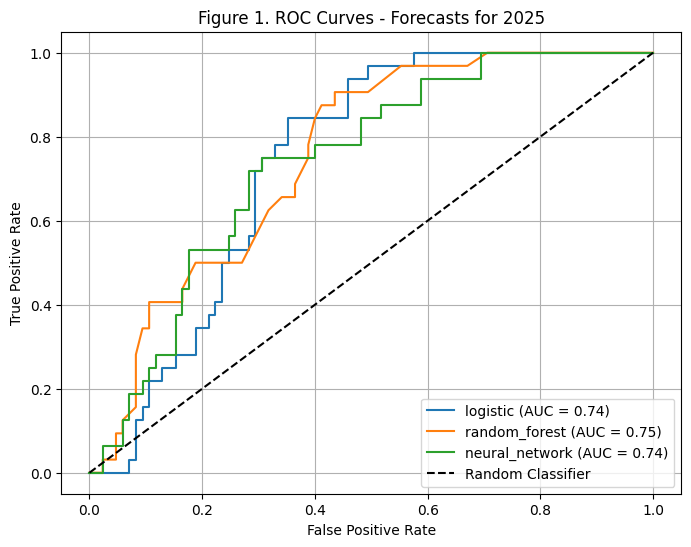


📊 Evaluating models for 2027 (Simulated Future)

🔮 Logistic (2027)
Auc: 0.539
Brier: 0.258
Sensitivity: 0.444
Specificity: 0.543
Accuracy: 0.513
Fp_tp: 2.312
Fn_tp: 1.250

🔮 Random_forest (2027)
Auc: 0.528
Brier: 0.229
Sensitivity: 0.083
Specificity: 0.889
Accuracy: 0.641
Fp_tp: 3.000
Fn_tp: 11.000

🔮 Neural_network (2027)
Auc: 0.489
Brier: 0.244
Sensitivity: 0.083
Specificity: 0.864
Accuracy: 0.624
Fp_tp: 3.667
Fn_tp: 11.000


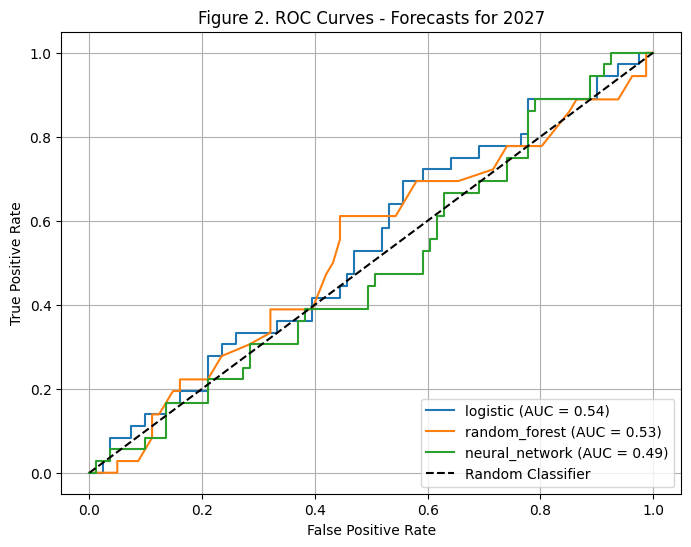

In [11]:
# 5. Plot ROC
def plot_roc_curves(results, title, save_path=None):
    plt.figure(figsize=(8, 6))
    for res in results:
        fpr, tpr, _ = roc_curve(res['labels'], res['probs'])
        plt.plot(fpr, tpr, label=f"{res['model']} (AUC = {res['auc']:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

#6. Future data
def create_future_data(X, years_ahead=2):
    future_X = X.copy()
    np.random.seed(42)
    for col in future_X.columns:
        if np.issubdtype(future_X[col].dtype, np.number):
            future_X[col] *= np.random.uniform(0.9, 1.1, size=len(future_X))
    return future_X
    
# 7. Run all
def main():
    df = fetch_and_save_data()
    df = preprocess(df)
    agg = extract_features(df)

    # 2025 
    X = agg.drop(columns=['month', 'time', 'violence_max'])
    y = agg['violence_max']

    print("\n Evaluating models for 2025")
    models = ['logistic', 'random_forest', 'neural_network']
    results_2025 = [evaluate_model(X, y, m) for m in models]

    for r in results_2025:
        print(f"\n {r['model'].capitalize()}")
        for k in ['auc', 'brier', 'sensitivity', 'specificity', 'accuracy', 'fp_tp', 'fn_tp']:
            print(f"{k.capitalize()}: {r[k]:.3f}")

    plot_roc_curves(results_2025, "Figure 1. ROC Curves - Forecasts for 2025")

    # 2027: future data 
    future_X = create_future_data(X)
    y_future = pd.Series(np.random.binomial(1, 0.3, size=len(future_X)))

    print("\n Evaluating models for 2027 (Simulated Future)")
    results_2027 = [evaluate_model(future_X, y_future, m) for m in models]

    for r in results_2027:
        print(f"\n {r['model'].capitalize()} (2027)")
        for k in ['auc', 'brier', 'sensitivity', 'specificity', 'accuracy', 'fp_tp', 'fn_tp']:
            print(f"{k.capitalize()}: {r[k]:.3f}")

    plot_roc_curves(results_2027, "Figure 2. ROC Curves - Forecasts for 2027")
    
main()